# Import libraries

In [1]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Reshape, Concatenate, Dot, Multiply

import math
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects


Using TensorFlow backend.


# Load Dataset

In [3]:
def load_dataset(dataset_id = 1):
    filename_train = '../data/train/u'+str(dataset_id)+'.base'
    filename_test = '../data/train/u'+str(dataset_id)+'.test'
    dataset_train_df = pd.read_csv(filename_train, names=['user_id','movie_id','rating','time_stamp'], header=None, delimiter='\t')
    dataset_test_df = pd.read_csv(filename_test, names=['user_id','movie_id','rating','time_stamp'], header=None, delimiter='\t')
    # dataset = dataset_df.to_dict('records')
    return dataset_train_df, dataset_test_df  
   

In [4]:
def one_hot_encoding(labels):
    encodeds = [
        [1., .0, .0, .0, .0],
        [.0, 1., .0, .0, .0],
        [.0, .0, 1., .0, .0],
        [.0, .0, .0, 1., .0],
        [.0, .0, .0, .0, 1.],
    ]
    labels_encoded = np.array([encodeds[int(label)-1] for label in labels])
    return labels_encoded

In [5]:
def one_hot_encoding_smoothing(labels):
    encodeds = [
        [.75, .25, .0, .0, .0],
        [.15, .7, .15, .0, .0],
        [.0, .15, .7, .15, .0],
        [.0, .0, .15, .7, .15],
        [.0, .0, .0, .25, .75],
    ]
    labels_encoded = np.array([encodeds[int(label)-1] for label in labels])
    return labels_encoded

In [6]:
dataset_train_df, dataset_test_df = load_dataset(dataset_id=1)

train_x_user = dataset_train_df['user_id'].values
train_x_item = dataset_train_df['movie_id'].values
train_y = dataset_train_df['rating'].values
train_y_encoded = one_hot_encoding(train_y)
train_y_encoded_smoothing = one_hot_encoding_smoothing(train_y)

test_x_user = dataset_test_df['user_id'].values
test_x_item = dataset_test_df['movie_id'].values
test_y = dataset_test_df['rating'].values
test_y_encoded = one_hot_encoding(test_y)
test_y_encoded_smoothing = one_hot_encoding_smoothing(test_y)

num_of_users = dataset_train_df['user_id'].max() + 1
num_of_items = dataset_train_df['movie_id'].max() + 1
num_of_factors = 100

# Scatter results

In [7]:
# Define our own plot function
def scatter(y, pred_y, subtitle='result.png'):
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    
    
    sc = ax.scatter(y, pred_y, lw=0, s=40)
    plt.xlim(-2, 7)
    plt.ylim(-2, 7)
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.savefig(subtitle)
    

### 3) model #3 - DNN with one-hot encoding

##### - build model

In [8]:
class DNNModel_onehot(Model):
    def __init__(self, num_of_users, num_of_items, num_of_factors):
        
        # tensor_0 : input
        input_user_id = Input((1,), name='input_user_id')
        input_item_id = Input((1,), name='input_item_id')
        
        # model_0 : embedding inpput
        model_Embedding_user_id = Sequential([
            Embedding(num_of_users, num_of_factors, input_length=1, input_shape=(1,)),
            Reshape((num_of_factors,)),
        ])
        model_Embedding_item_id = Sequential([
            Embedding(num_of_items, num_of_factors, input_length=1, input_shape=(1,)),
            Reshape((num_of_factors,)),
        ])
        
        # tensor_1 : embedded input
        embedded_user_id = model_Embedding_user_id(input_user_id)
        embedded_item_id = model_Embedding_item_id(input_item_id)
        
        # tensor_2 : embedded vector
        embedded_mul = Multiply()([embedded_user_id, embedded_item_id])
        embedded_vector = Concatenate(axis=-1)([embedded_user_id, embedded_item_id, embedded_mul])
        
        # model_2 : DNN
        p_dropout=0.1
        model_DNN = Sequential([
            Dropout(p_dropout),
            Dense(num_of_factors * 3, activation='relu'),
            Dropout(p_dropout),
            Dense(30, activation='relu'),
            Dropout(p_dropout),
            Dense(5, activation='softmax'),
        ])    
        
        # tensor_3 : output_label
        output_label = model_DNN(embedded_vector)
        
        super(DNNModel_onehot, self).__init__(
            inputs=[input_user_id, input_item_id], 
            outputs=output_label
        )

    def score(self, y, pred_y):
        return np.sqrt( np.sum(np.square(pred_y.reshape(-1, 1) - y.reshape(-1,1))) / len(y) )
        

### - train model and get results

##### 3_a) one-hot encoding

In [9]:
model = DNNModel_onehot(num_of_users, num_of_items, num_of_factors)
model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(),
)
#model.summary()

In [10]:
callbacks = [
    tf.keras.callbacks.EarlyStopping('val_loss', patience=5),
]
result = model.fit(
    [train_x_user, train_x_item], train_y_encoded,
    batch_size = 512,
    epochs = 1000,
    shuffle = True,
    verbose = True,
    validation_data = ([test_x_user, test_x_item], test_y_encoded),
    callbacks = callbacks,
)

model.save_weights('weights_DNN_onehot.h5')

Train on 80000 samples, validate on 20000 samples
Epoch 1/1000
80000/80000 [==============================] - 2s 27us/sample - loss: 0.1423 - val_loss: 0.1349
Epoch 2/1000
80000/80000 [==============================] - 1s 12us/sample - loss: 0.1323 - val_loss: 0.1331
Epoch 3/1000
80000/80000 [==============================] - 1s 12us/sample - loss: 0.1297 - val_loss: 0.1332
Epoch 4/1000
80000/80000 [==============================] - 1s 11us/sample - loss: 0.1278 - val_loss: 0.1332
Epoch 5/1000
80000/80000 [==============================] - 1s 12us/sample - loss: 0.1261 - val_loss: 0.1337
Epoch 6/1000
80000/80000 [==============================] - 1s 11us/sample - loss: 0.1245 - val_loss: 0.1344
Epoch 7/1000
80000/80000 [==============================] - 1s 11us/sample - loss: 0.1228 - val_loss: 0.1351


RMSE :  1.3567424221273543


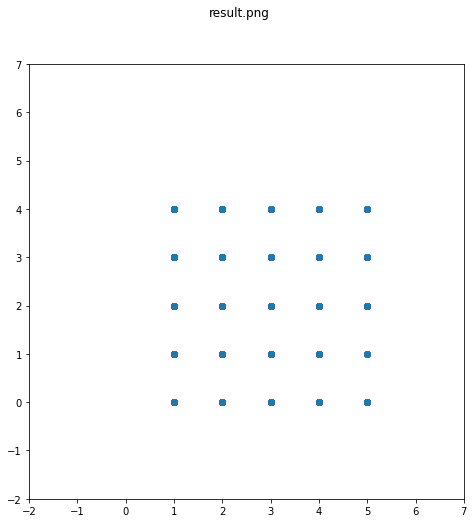

In [11]:
pred_y_encoded = model.predict([test_x_user, test_x_item]).reshape(-1,1)
pred_y = pred_y_encoded.reshape(-1,5,).argmax(axis=1)

print('RMSE : ', model.score(test_y, pred_y))
scatter(test_y, pred_y)

##### 3_b) one-hot encoding with smoothing

In [12]:
model = DNNModel_onehot(num_of_users, num_of_items, num_of_factors)
model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(),
)
#model.summary()

In [13]:
callbacks = [
    tf.keras.callbacks.EarlyStopping('val_loss', patience=5),
]
result = model.fit(
    [train_x_user, train_x_item], train_y_encoded_smoothing,
    batch_size = 512,
    epochs = 1000,
    shuffle = True,
    verbose = True,
    validation_data = ([test_x_user, test_x_item], test_y_encoded_smoothing),
    callbacks = callbacks,
)

model.save_weights('weights_DNN_onehot_smoothing.h5')

Train on 80000 samples, validate on 20000 samples
Epoch 1/1000
80000/80000 [==============================] - 2s 22us/sample - loss: 0.0583 - val_loss: 0.0540
Epoch 2/1000
80000/80000 [==============================] - 1s 13us/sample - loss: 0.0523 - val_loss: 0.0527
Epoch 3/1000
80000/80000 [==============================] - 1s 14us/sample - loss: 0.0509 - val_loss: 0.0524
Epoch 4/1000
80000/80000 [==============================] - 1s 18us/sample - loss: 0.0501 - val_loss: 0.0523
Epoch 5/1000
80000/80000 [==============================] - 1s 12us/sample - loss: 0.0494 - val_loss: 0.0522
Epoch 6/1000
80000/80000 [==============================] - 1s 12us/sample - loss: 0.0487 - val_loss: 0.0522
Epoch 7/1000
80000/80000 [==============================] - 1s 12us/sample - loss: 0.0479 - val_loss: 0.0523
Epoch 8/1000
80000/80000 [==============================] - 1s 12us/sample - loss: 0.0470 - val_loss: 0.0526
Epoch 9/1000
80000/80000 [==============================] - 1s 12us/sample - l

RMSE :  1.4007141035914503


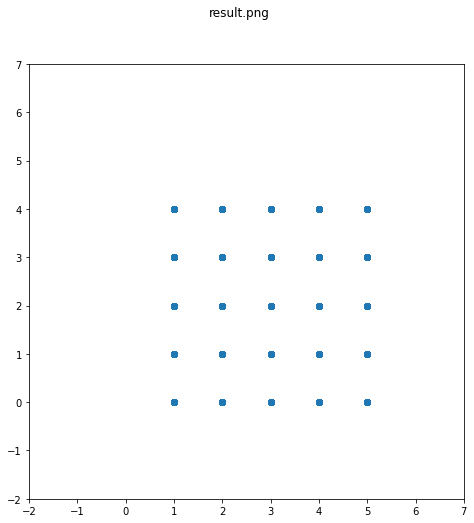

In [14]:
pred_y_encoded = model.predict([test_x_user, test_x_item]).reshape(-1,1)
pred_y = pred_y_encoded.reshape(-1,5,).argmax(axis=1)

print('RMSE : ', model.score(test_y, pred_y))
scatter(test_y, pred_y)

##### 3_c) one-hot encoding - ce

In [15]:
model = DNNModel_onehot(num_of_users, num_of_items, num_of_factors)
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
)
#model.summary()

In [16]:
callbacks = [
    tf.keras.callbacks.EarlyStopping('val_loss', patience=5),
]
result = model.fit(
    [train_x_user, train_x_item], train_y_encoded,
    batch_size = 512,
    epochs = 1000,
    shuffle = True,
    verbose = True,
    validation_data = ([test_x_user, test_x_item], test_y_encoded),
    callbacks = callbacks,
)

model.save_weights('weights_DNN_onehot_ce.h5')

Train on 80000 samples, validate on 20000 samples
Epoch 1/1000
80000/80000 [==============================] - 2s 22us/sample - loss: 0.4423 - val_loss: 0.4159
Epoch 2/1000
80000/80000 [==============================] - 1s 12us/sample - loss: 0.4082 - val_loss: 0.4096
Epoch 3/1000
80000/80000 [==============================] - 1s 12us/sample - loss: 0.3997 - val_loss: 0.4086
Epoch 4/1000
80000/80000 [==============================] - 1s 12us/sample - loss: 0.3941 - val_loss: 0.4095
Epoch 5/1000
80000/80000 [==============================] - 1s 12us/sample - loss: 0.3893 - val_loss: 0.4093
Epoch 6/1000
80000/80000 [==============================] - 1s 12us/sample - loss: 0.3847 - val_loss: 0.4104
Epoch 7/1000
80000/80000 [==============================] - 1s 12us/sample - loss: 0.3796 - val_loss: 0.4135
Epoch 8/1000
80000/80000 [==============================] - 1s 12us/sample - loss: 0.3741 - val_loss: 0.4151


RMSE :  1.3840700849306729


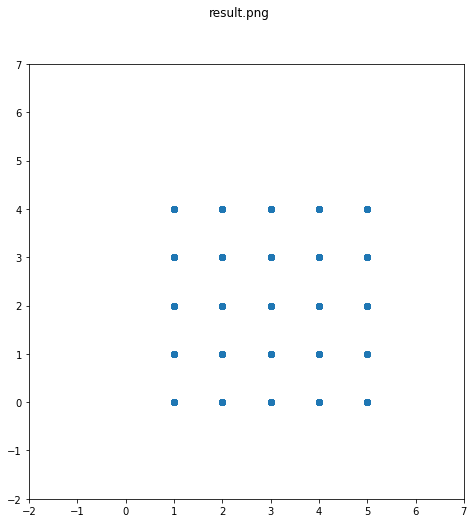

In [17]:
pred_y_encoded = model.predict([test_x_user, test_x_item]).reshape(-1,1)
pred_y = pred_y_encoded.reshape(-1,5,).argmax(axis=1)

print('RMSE : ', model.score(test_y, pred_y))
scatter(test_y, pred_y)

##### 3_d) one-hot encoding with smoothing - ce

In [18]:
model = DNNModel_onehot(num_of_users, num_of_items, num_of_factors)
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
)
#model.summary()

In [19]:
callbacks = [
    tf.keras.callbacks.EarlyStopping('val_loss', patience=5),
]
result = model.fit(
    [train_x_user, train_x_item], train_y_encoded_smoothing,
    batch_size = 512,
    epochs = 1000,
    shuffle = True,
    verbose = True,
    validation_data = ([test_x_user, test_x_item], test_y_encoded_smoothing),
    callbacks = callbacks,
)

model.save_weights('weights_DNN_onehot_smoothing_ce.h5')

Train on 80000 samples, validate on 20000 samples
Epoch 1/1000
80000/80000 [==============================] - 2s 24us/sample - loss: 0.4529 - val_loss: 0.4370
Epoch 2/1000
80000/80000 [==============================] - 1s 12us/sample - loss: 0.4335 - val_loss: 0.4327
Epoch 3/1000
80000/80000 [==============================] - 1s 12us/sample - loss: 0.4285 - val_loss: 0.4314
Epoch 4/1000
80000/80000 [==============================] - 1s 13us/sample - loss: 0.4253 - val_loss: 0.4313
Epoch 5/1000
80000/80000 [==============================] - 1s 12us/sample - loss: 0.4225 - val_loss: 0.4310
Epoch 6/1000
80000/80000 [==============================] - 1s 12us/sample - loss: 0.4194 - val_loss: 0.4312
Epoch 7/1000
80000/80000 [==============================] - 1s 12us/sample - loss: 0.4155 - val_loss: 0.4314
Epoch 8/1000
80000/80000 [==============================] - 1s 12us/sample - loss: 0.4103 - val_loss: 0.4338
Epoch 9/1000
80000/80000 [==============================] - 1s 12us/sample - l

RMSE :  1.4425844862606834


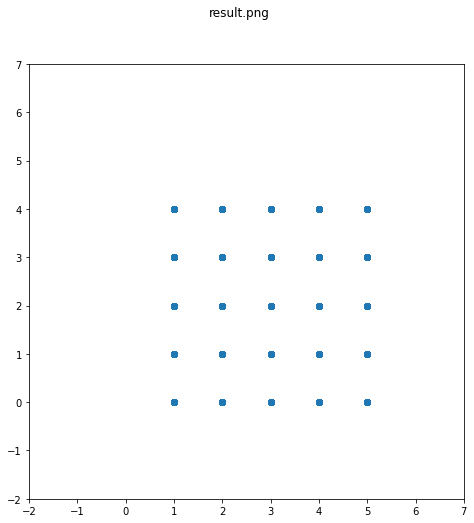

In [20]:
pred_y_encoded = model.predict([test_x_user, test_x_item]).reshape(-1,1)
pred_y = pred_y_encoded.reshape(-1,5,).argmax(axis=1)

print('RMSE : ', model.score(test_y, pred_y))
scatter(test_y, pred_y)